## Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob as gb
import random
import os
import cv2
from google.colab import drive
from google.colab import files

# Downloading the dataset
git_folder = "/content/ANN-with-Momentum/"
if os.path.exists(git_folder) == False:
  !git clone https://github.com/DhilipSanjay/ANN-with-Momentum.git

Cloning into 'ANN-with-Momentum'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 380 (delta 24), reused 51 (delta 22), pack-reused 319
Receiving objects: 100% (380/380), 87.58 MiB | 35.67 MiB/s, done.
Resolving deltas: 100% (24/24), done.


## Load Dataset

In [ ]:
dataset_folder = git_folder + "Ambulance Dataset/"

# To create y-values for the images in the respective folders
code = {"ambulance" : 1 , "non-ambulance" : 0}

def place(n):
  for item in code:
    if n == code[item]:
      return item

train = dataset_folder + "train/"
test = dataset_folder + "test/"

image_resize = 128

train_data = []
xtrain = []
ytrain = []

# Training images
for folder in os.listdir(train):
  files = gb.glob(pathname=str(train + folder + "/*.jpg"))
  for file in files: 
    train_image=plt.imread(file)
    image_size=cv2.resize(train_image,(image_resize,image_resize))
    train_data.append([np.array(image_size), code[folder]])

print("Train Data Size: ", len(train_data))

# Shuffle the training images
random.shuffle(train_data)
for td in train_data:
  xtrain.append(td[0])
  ytrain.append(td[1])


test_data = []
xtest = []
ytest = []

# Testing images
for folder in os.listdir(test):
  files = gb.glob(pathname=str(test + folder + "/*.jpg"))
  for file in files: 
    test_image=plt.imread(file)
    image_size=cv2.resize(test_image,(image_resize,image_resize))
    test_data.append([np.array(image_size), code[folder]])

print("Test Data Size: ", len(test_data))

# Shuffle the testing images
random.shuffle(test_data)
for td in test_data:
  xtest.append(td[0])
  ytest.append(td[1])


x_train = np.array(xtrain)
y_train = np.array(ytrain)
x_test = np.array(xtest)
y_test = np.array(ytest)

Train Data Size:  260
Test Data Size:  50


## Display sample images

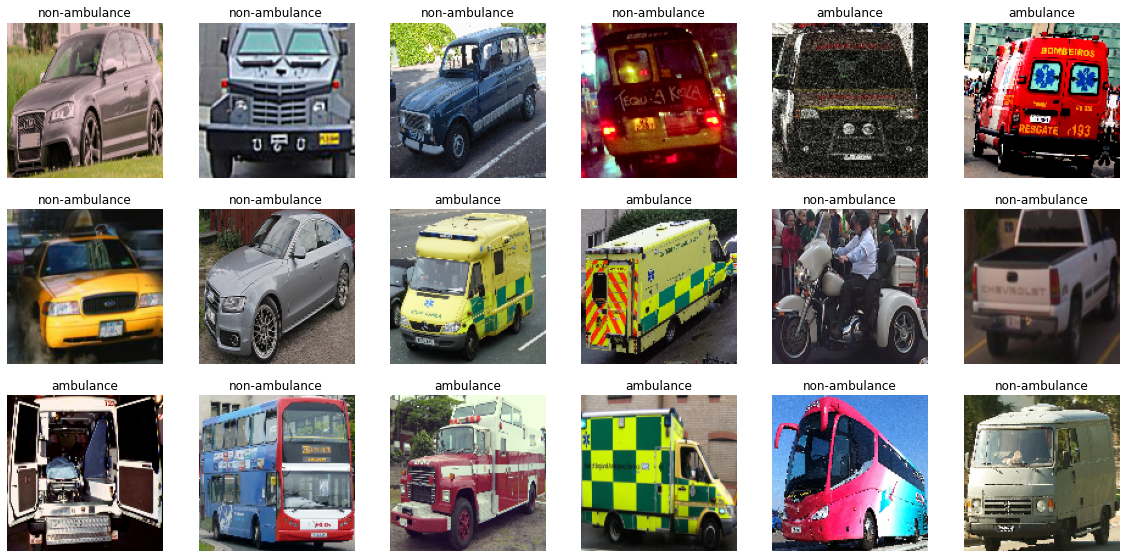

In [ ]:
code = dict([(value, key) for key, value in code.items()])
plt.figure(figsize=(20,20))
for i in range(18):
  plt.subplot(6,6,i+1)
  plt.axis("off")
  plt.title(code[y_train[i]])
  plt.imshow(x_train[i])

## Preprocess Dataset

In [ ]:
x_train = x_train.reshape(x_train.shape[0], -1, 1)
x_test = x_test.reshape(x_test.shape[0], -1, 1)
y_train = y_train.reshape((y_train.shape[0], 1))
y_test  = y_test .reshape((y_test .shape[0], 1))

x_train = x_train/255
x_test = x_test/255

print("Training data x-values:", x_train.shape)
print("Training data y-values:", y_train.shape)
print("Testing data x-values:", x_test.shape)
print("Testing data y-values:",y_test.shape)

Training data x-values: (260, 49152, 1)
Training data y-values: (260, 1)
Testing data x-values: (50, 49152, 1)
Testing data y-values: (50, 1)


## Initialize Weights and Biases

In [ ]:
def initialize_layers(layers):

  # np.random.seed(0)
  # Store the weights and biases in dictionary
  WB = {}
  
  for l in range(1, len(layers)):
    # Weight dim = [current layer dim, prev layer dim]
    WB["W" + str(l)] =  np.random.randn(layers[l], layers[l-1]) * 0.01 #np.full((layers[l], layers[l-1]), 0.1)
    print("W"+str(l) , WB["W" + str(l)].shape)

    # Weight gradients initialized to zero (for backprop)
    WB["dW" + str(l)] =  np.zeros((layers[l], layers[l-1]))
    print("dW"+str(l) , WB["dW" + str(l)].shape)

    # Bias dim = [current layer dim]
    WB["b" + str(l)] = np.ones((layers[l], 1)) *0.01 #np.full(layers[l], 0.1)
    print("b"+str(l) , WB["b" + str(l)].shape)

    WB["db" + str(l)] = np.zeros((layers[l], 1))
    print("db"+str(l) , WB["db" + str(l)].shape)

  return WB

## Activation Function

In [ ]:
def sigmoid(net):
  '''
  Calculate sigmoid activation value
  '''
  return 1/(1+np.exp(-net))

## Forward Propagation

In [ ]:
def linear_activation_forward(X, W, b):
  '''
  Calculate net value
  Calculate the sigmoid activation value for net
  
  History - Stores the inputs, Weights and biases
  '''
  net = np.dot(W, X) + b
  output = sigmoid(net)
  history = (X, W, b)
  
  return output, history

In [ ]:
def model_linear_activation_forward(WB, X, layers):
  '''
  For an training example
    store the history
    Calculate it's output
  '''
  output = X
  length = len(layers)
  
  for l in range(1, length):
    output_prev = output
    W = WB["W" + str(l)]
    b = WB["b" + str(l)]
    WB["X" + str(l)] = output_prev
    output, history = linear_activation_forward(output_prev, W, b)
    
  return output, WB

## Backward propagation

In [ ]:
def error_output_unit(T, O):
  '''
  T - Target Values
  O - Output Values
  '''
  E = O * (1 - O) * (T - O)

  return E

In [ ]:
def error_hidden_unit(W, E, O):
  '''
  W - weight to the next layer
  E - Error calculated for the next layer
  O - Output of the current layer
  '''
  W = W.T
  S = np.sum(np.dot(W, E))
  E = O * (1 - O) * S
  
  return E

In [ ]:
def weight_update(W, b, E, X, LR, alpha, prevDW, prevDb):
  '''
  W - original weights
  b - biases
  E - Error values
  X - Input values
  LR - Learning Rate

  dW - weight updates
  db - bias updates

  AW - altered weights
  Ab - altered biases

  alpha - momentum (if 0 -> no momentum)
  prevDW - dW of previous iteration
  prevDb - db of previous iteration
  '''
  dW = LR * np.dot(E, X.T)
  db = LR * E * 1
  
  AW = W  + dW + (alpha * prevDW)
  Ab = b + db + (alpha * prevDb)

  return AW, dW, Ab, db

In [ ]:
def back_prop_output_unit(T, O, W, b, X, LR, alpha, prevDW, prevDb):
  E = error_output_unit(T, O)
  AW, dW, Ab, db = weight_update(W, b, E, X, LR, alpha, prevDW, prevDb)

  return E, AW, dW, Ab, db

def back_prop_hidden_unit(Wnext, Enext, O, W, b, X, LR, alpha, prevDW, prevDb):
  E = error_hidden_unit(Wnext, Enext, O)
  AW, dW, Ab, db = weight_update(W, b, E, X, LR, alpha, prevDW, prevDb)

  return E, AW, dW, Ab, db

In [ ]:
def model_back_prop(WB, O, T, LR, layers, alpha):

  length = len(layers) - 1
  W = WB["W" + str(length)] 
  X = WB["X" + str(length)] 
  b = WB["b" + str(length)]
  prevDW = WB["dW" + str(length)] 
  prevDb = WB["db" + str(length)]

  E, W, dW, b, db = back_prop_output_unit(T, O, W, b, X, LR, alpha, prevDW, prevDb)

  # Update dW, db Error (for Adding momentum)
  WB["dW" + str(length)] = dW
  WB["E" + str(length)] = E
  WB["db" + str(length)] = db

  # Update the weights, biases (for Adding momentum)
  WB["W" + str(length)] = W
  WB["b" + str(length)] = b
  
  for l in range(length-1, 0, -1):
    # Next layers's weight and error (previously calculated)
    Wnext = W
    Enext = E

    # Current layer's output (i.e) next layers input
    O = X 

    # Current layer's weights and biases
    W = WB["W" + str(l)] 
    b = WB["b" + str(l)]

    # Input to current layer
    X = WB["X" + str(l)] 
    prevDW = WB["dW" + str(l)] 
    prevDb = WB["db" + str(l)]
    
    # Update weights
    E, W, dW, Ab, db = back_prop_hidden_unit(Wnext, Enext, O, W, b, X, LR, alpha, prevDW, prevDb)
    
    # Update dW, db Error (for Adding momentum)
    WB["dW" + str(l)] = dW
    WB["E" + str(l)] = E
    WB["db" + str(l)] = db

    # Update the weights, biases (for Adding momentum)
    WB["W" + str(l)] = W
    WB["b" + str(l)] = b
  return WB

## Training the model

In [ ]:
def train_model(WB, x_train, y_train, num_epochs, LR, layers, alpha, history):
  total_ex = len(x_train)

  # Run the model for the given number of epochs
  for e in range(num_epochs):
    print("Epoch ", e+1)
    error = 0
    accuracy = 0
    for i in range(total_ex):
      # Forward Propagation
      output, WB = model_linear_activation_forward(WB, x_train[i], layers)
      # Backward Propagation
      WB = model_back_prop(WB, output, y_train[i], LR, layers, alpha)
      # Accuracy and Error
      error += (y_train[i] - output) ** 2
      if (output >= 0.5 and y_train[i] == 1) or (output < 0.5 and y_train[i] == 0):
        accuracy += 1

    # Calculate the final accuracy and error
    final_error = np.squeeze(error)/total_ex
    history["error"].append(final_error)
    final_accuracy = accuracy/total_ex
    history["accuracy"].append(final_accuracy)
    print("Error: ", final_error, "\tAccuracy: ", final_accuracy)
    
    # To avoid overfitting
    if final_accuracy >= 0.995:
      print("99.5% Accuracy reached. Stopping the training")
      break

## Testing the model

In [ ]:
def model_predict(WB, X, layers):
  output = X
  
  for l in range(1, len(layers)):
    output_prev = output
    W = WB["W" + str(l)]
    b = WB["b" + str(l)]
    output, history = linear_activation_forward(output_prev, W, b)

  return output

In [ ]:
def test_model(WB, x_test, y_test, layers):
  total_ex = len(x_test)
  error = 0
  accuracy = 0
  # Predict for all the test examples
  for i in range(total_ex):
    output = model_predict(WB, x_test[i], layers)
    #print("Predicted Output: ", np.squeeze(output),  "\tTest Output: ", np.squeeze(y_test[i]))

    # Calculate the error and accuracy
    error += (y_test[i] - output) ** 2
    if (output >= 0.5 and y_test[i] == 1) or (output < 0.5 and y_test[i] == 0):
      accuracy += 1

  # Calculate the final accuracy and error
  final_error = np.squeeze(error)/total_ex
  final_accuracy = accuracy/total_ex

  print("Error: ", final_error, "\tAccuracy: ", final_accuracy)

## Plot Accuracy and Error graph

In [ ]:
def plot_graphs(history, string):
  plt.plot(history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string])
  plt.show()

# ANN Without Momentum

In [ ]:
input_layer = x_train.shape[1]
hidden_1 = 32
output_layer = 1
layers = [input_layer, hidden_1, output_layer]
WB = initialize_layers(layers)
history = {"accuracy" : [],
           "error" : []}

num_epochs = 500
LR = 0.005
alpha = 0

train_model(WB, x_train, y_train, num_epochs, LR, layers, alpha, history)

W1 (32, 49152)
dW1 (32, 49152)
b1 (32, 1)
db1 (32, 1)
W2 (1, 32)
dW2 (1, 32)
b2 (1, 1)
db2 (1, 1)
Epoch  1
Error:  0.25129092828295957 	Accuracy:  0.49230769230769234
Epoch  2
Error:  0.24949319239368167 	Accuracy:  0.5076923076923077
Epoch  3
Error:  0.2422306440447131 	Accuracy:  0.5
Epoch  4
Error:  0.22706452036073613 	Accuracy:  0.5653846153846154
Epoch  5
Error:  0.20948068391300548 	Accuracy:  0.6730769230769231
Epoch  6
Error:  0.19326220865106164 	Accuracy:  0.7615384615384615
Epoch  7
Error:  0.17779761764366153 	Accuracy:  0.8
Epoch  8
Error:  0.16352648083317764 	Accuracy:  0.8423076923076923
Epoch  9
Error:  0.15099379545588548 	Accuracy:  0.8769230769230769
Epoch  10
Error:  0.14007684618288777 	Accuracy:  0.9153846153846154
Epoch  11
Error:  0.12992589141356248 	Accuracy:  0.9384615384615385
Epoch  12
Error:  0.12013738718448744 	Accuracy:  0.9423076923076923
Epoch  13
Error:  0.11109020858492448 	Accuracy:  0.95
Epoch  14
Error:  0.10333839887387819 	Accuracy:  0.961538

In [ ]:
# Without momentum test accuracy
test_model(WB, x_test, y_test, layers)

Error:  0.2185645468852183 	Accuracy:  0.7


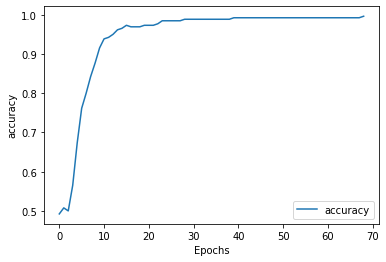

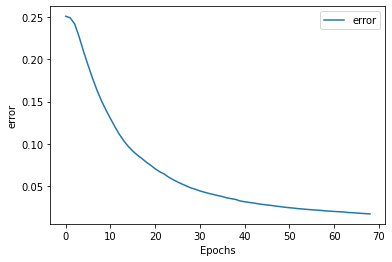

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "error")

# ANN With Momentum

In [ ]:
input_layer = x_train.shape[1]
hidden_1 = 32
output_layer = 1
layers = [input_layer, hidden_1, output_layer]
WB = initialize_layers(layers)
history = {"accuracy" : [],
           "error" : []}

num_epochs = 500
LR = 0.005
alpha = 0.3

train_model(WB, x_train, y_train, num_epochs, LR, layers, alpha, history)

W1 (32, 49152)
dW1 (32, 49152)
b1 (32, 1)
db1 (32, 1)
W2 (1, 32)
dW2 (1, 32)
b2 (1, 1)
db2 (1, 1)
Epoch  1
Error:  0.25133459561082133 	Accuracy:  0.47692307692307695
Epoch  2
Error:  0.25176351230082455 	Accuracy:  0.47307692307692306
Epoch  3
Error:  0.251105977236114 	Accuracy:  0.4807692307692308
Epoch  4
Error:  0.24794839024517012 	Accuracy:  0.5576923076923077
Epoch  5
Error:  0.23783047077043915 	Accuracy:  0.6230769230769231
Epoch  6
Error:  0.22255214723166164 	Accuracy:  0.6230769230769231
Epoch  7
Error:  0.20461679774824412 	Accuracy:  0.7076923076923077
Epoch  8
Error:  0.18661942227043898 	Accuracy:  0.7923076923076923
Epoch  9
Error:  0.16937686087494655 	Accuracy:  0.8192307692307692
Epoch  10
Error:  0.15462718107814322 	Accuracy:  0.8884615384615384
Epoch  11
Error:  0.14117445079427424 	Accuracy:  0.9230769230769231
Epoch  12
Error:  0.1300995319812747 	Accuracy:  0.9307692307692308
Epoch  13
Error:  0.12013654009999936 	Accuracy:  0.9384615384615385
Epoch  14
Error

In [ ]:
# With momentum test accuracy
test_model(WB, x_test, y_test, layers)

Error:  0.2235885868834997 	Accuracy:  0.7


In [ ]:
# plot_graphs(history, "accuracy")
# plot_graphs(history, "error")

## Test with your own image

In [ ]:
# Change the size according to the training example
from google.colab import files
uploaded = files.upload()
result = dict()


for fn in uploaded.keys():
  image = cv2.imread(fn)
  image_np = cv2.resize(image, (image_resize,image_resize))  

  image_np = image_np.reshape(-1, 1) / 255
  output = model_predict(WB, image_np, layers)
  print("\n--------------------------")
  print("Predicted Output: ", np.squeeze(output))
  if output >= 0.5:
    print(fn + " is an ambulance\n")
    result[fn] = "ambulance"
  else:
    print(fn + " is not an ambulance\n")
    result[fn] = "non-ambulance"

plt.figure(figsize=(20,20))
   
for i, fn in enumerate(uploaded.keys()):
  image = plt.imread(fn)  
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  plt.imshow(image)
  ans = fn + ": " + result[fn]
  plt.title(ans)